# 准备参数

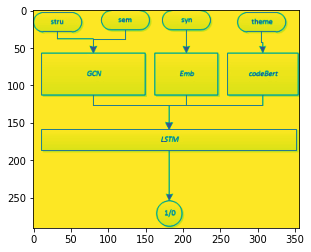

In [1]:
# 
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("D:\\研究生\\研究内容\\研究生开题\\工作空间\\最终版实验程序和数据备份\\examination_2\\model-2.jpg")
# img.show() # 会调用系统的显示窗口
plt.figure('image')
plt.imshow(img)
plt.show()


In [1]:

# 作者：常晓松
# 作用：日志等级预测
# 时间： 2024/7/9 19:31
from imblearn.over_sampling import SMOTE
from scipy.sparse import diags
import scipy
import stellargraph as sg
from playsound import playsound
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *
from keras import Model, Input
from keras import losses
from keras.callbacks import EarlyStopping
import torch
import os
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
from sklearn.metrics import balanced_accuracy_score
from numpy import sort
from random import random
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
from keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import pdist
import pandas as pd
from tqdm import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import pymysql
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import time
import pickle
from sklearn.model_selection import train_test_split  # 出留法
from keras.layers import Convolution1D, MaxPooling1D, LSTM
import random
import numpy
import math
from statistics import mean

def get_ave_and_standard_error(data_list):

    SD_P = numpy.std(data_list, ddof=0)
    n = len(data_list)

    ave = mean(data_list)
    standard_error = SD_P / math.sqrt(n)
    return round(ave,3),round(standard_error,3)

def get_connection():
    global conn
    host = "127.0.0.1"
    user = "root"
    password = 'chang123'
    db = 'predict_log_final'
    conn = pymysql.connect(
        host=host,
        user=user,
        password=password,
        db=db,
        charset='utf8',
        # autocommit=True,    # 如果插入数据，， 是否自动提交? 和conn.commit()功能一致。
    )
    return conn

def shuffle_data(node, semantic_vec, syntatic_vec,leaf_method_name_vec,lable, seed):
    c = list(zip(node, semantic_vec, syntatic_vec,leaf_method_name_vec,lable))  # 将a,b整体作为一个zip,每个元素一一对应后打乱
    random.seed(seed)
    random.shuffle(c)  # 打乱c
    node[:], semantic_vec[:], syntatic_vec[:],leaf_method_name_vec[:],lable[:] = zip(*c)  # 将打乱的c解开
    return node, semantic_vec, syntatic_vec,leaf_method_name_vec,lable



def get_method_name_emb(seq):
    cur = conn.cursor()
    sqli = "select method_name_emb from data_model_1 where seq=( select methodSeq from data_model_2 where seq=" + str(seq) + ")"
    result = cur.execute(sqli)
    oneRow = cur.fetchone()
    emb=oneRow[0]
    cur.close()
    return eval(emb)



def get_positive_data_from_db(vec_length):
    cur = conn.cursor()
    sqli = "select vectorStruct,logNum from data_model_2 where logNum<>0 and vectorStruct is not null;"
    result = cur.execute(sqli)
    methods_padding = np.empty(shape=[0, vec_length], dtype=int)
    labels = []
    for i in range(result):
        oneRow = cur.fetchone()
        methods_padding = string_vector_to_int(methods_padding, oneRow)
        labels.append(oneRow[1])
    return methods_padding, labels



def add_nagitive_data(methods_padding, lables):
    cur = conn.cursor()
    sqli = "select vectorStruct,logNum from data_model_2 where logNum=0 and vectorStruct is not null limit " + str(
        len(methods_padding)) + ";"
    result = cur.execute(sqli)
    for i in range(1, len(methods_padding)):
        oneRow = cur.fetchone()
        methods_padding = string_vector_to_int(methods_padding, oneRow)
        lables.append(oneRow[1])
    return methods_padding, lables


def string_vector_to_int(methods_padding, oneRow):
    methods_padding = np.append(methods_padding, [list(map(int, oneRow[0][1:len(oneRow[0]) - 1].split(",")))], axis=0)
    return methods_padding


def float_revert_int(value_list):
    revert_value_list = []
    for i in value_list:
        revert_value_list.append(int(np.round(i)))
    value_list = revert_value_list
    return revert_value_list


def draw_confusion_matrix(y_true, y_pred, dic_lables):

    plt.cla()

    labels = []
    for key in dic_lables:
        labels.append(key)
    print_message(type(labels))
    # 小数转整数
    y_pred_int = float_revert_int(y_pred)
    sns.set()
    f, ax = plt.subplots()
    C2 = confusion_matrix(y_true,y_pred,  labels=labels)
    print_message(C2)  # 打印出来看看
    sns.heatmap(C2, annot=True, fmt='.20g', ax=ax, cmap="YlGnBu")  # 画热力图
    ax.set_title('confusion matrix')  # 标题
    ax.set_xlabel('true')  # x轴
    ax.set_ylabel('predict')  # y轴
    save_pic(plt, '混淆矩阵')
    # plt.show()
    return plt


def save_pic(plt, file_name):
    # 创建目录
    dirs = 'C:\\Users\\chang\\Desktop\\日志工作空间\\实验图片\\'
    t = time.strftime('%Y-%m-%d-%H', time.localtime(int(time.time())))
    dirs = dirs + t
    file = dirs + '\\' + file_name + '.png'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    if os.path.exists(file):
        os.remove(file)
    # 保存图片
    plt.savefig(file)  # 保存图片


def plot_value(y_true, y_pred):
    balance_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = sk.metrics.precision_score(y_true, y_pred)
    recall = sk.metrics.recall_score(y_true, y_pred)
    f1_value = sk.metrics.f1_score(y_true, y_pred)
    return balance_accuracy, precision, recall, f1_value


def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


def plot_graphs(history_loc, type_loc):
    plt.cla()

    plt.plot(history_loc.history[type_loc])
    plt.plot(history_loc.history['val_' + type_loc])
    plt.xlabel('Epochs')
    plt.ylabel(type_loc)
    plt.legend([type_loc, 'val_' + type_loc])
    save_pic(plt, type_loc)
    # plt.show()
    return plt


def str_revert_to_list(methods_padding, max_len):
    methods_padding_list = np.empty(shape=[0, max_len], dtype=int)

    for methods_padding_one in methods_padding:
        list1 = methods_padding_one.split(',')
        list1 = list(map(int, list1))
        methods_padding_list = np.append(methods_padding_list, [np.array(list1)], axis=0)  # 添加整行元素，axis=1添加整列元素
    return methods_padding_list


def get_object(save_absolute_path):
    summer_load = None
    with open(save_absolute_path, 'rb') as f:
        summer_load = pickle.load(f)  # read file and build object
    return summer_load


def save_object(summer_save, save_absolute_path):
    summer_save = pickle.dumps(summer_save)
    with open(save_absolute_path, 'wb') as f:  # open file with write-mode
        f.write(summer_save)  # serialize and save object


def get_parent(vec_chair):
    cur = conn.cursor()
    sqli = "select parentId from data_model_2 where seq=" + str(vec_chair[len(vec_chair) - 1]) + ";"
    result = cur.execute(sqli)
    oneRow = cur.fetchone()
    if oneRow[0] == 0:
        return vec_chair
    else:
        vec_chair.append(oneRow[0])
        return get_parent(vec_chair)


def get_chair_vec(vec_chair, i,maxlen):
    cur = conn.cursor()
    one_leaf_list = []
    leaf = True
    message_type = i
    for one_leaf in vec_chair:
        sqli = "select a.vectorSemantic,REPLACE(REPLACE(vectorStruct,'[',''),']',''),logNum ,REPLACE(REPLACE(syntacticMessage,'[',''),']','') " \
               "from data_model_2 a  where seq=" + str(one_leaf) + ";"
        result = cur.execute(sqli)
        oneRow = cur.fetchone()
        vectorSemantic = oneRow[0]
        vectorStruct = oneRow[1]
        logNum = oneRow[2]
        syntacticMessage = oneRow[3]
        if vectorSemantic != "[]":
            if message_type == 1 or message_type == 3:
                if vectorSemantic is not None :
                    if len(vectorSemantic)==0:
                        vectorSemantic='0'
                    list_semantic = vectorSemantic.split(',')
                    list_semantic = list(map(float, list_semantic))
                    list_semantic_tmp = pad_sequences([list_semantic], maxlen=maxlen,
                                                      padding="post", truncating="post", dtype='float32')
                    list_semantic = list_semantic_tmp[0]
                    one_leaf_list.extend(list_semantic)
                    # one_leaf_list.extend([0,0,0,0])
            if message_type == 2:
                if syntacticMessage is not None :
                    if len(syntacticMessage)==0:
                        syntacticMessage='0'
                    list_syntactic = syntacticMessage.split(',')
                    list_syntactic = list(map(float, list_syntactic))
                    list_syntactic_tmp = pad_sequences([list_syntactic], maxlen=maxlen,
                                                       padding="post", truncating="post", dtype='float32')
                    list_syntactic = list_syntactic_tmp[0]
                    one_leaf_list.extend(list_syntactic)
    cur.close()
    return one_leaf_list


def print_message(message):
    t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(time.time())))
    print('时间：' + t, end=" ", flush=True)
    print(message, flush=True)



def repetition_list(a):
    repetition = 6
    c = []
    for a_one in a:
        b = []
        for a_single in a_one:
            for i in range(repetition):
                b.append(a_single)
        c.append(b)
    return c


def overlap_channel(a, b):
    element_num = 0
    height = 0
    width = 0
    if len(a.shape) == 2:
        element_num = a.shape[0]
        height = 1
        width = a.shape[1]
    elif len(a.shape) == 3:
        element_num = a.shape[0]
        height = a.shape[1]
        width = a.shape[2]
    else:
        raise Exception(print_message('通道叠加 不支持这类维度:' + str(a.shape)))

    a = a.reshape(element_num, 1, height, width)
    b = b.reshape(element_num, 1, height, width)
    a = a.transpose(1, 0, 2, 3)
    b = b.transpose(1, 0, 2, 3)
    c = np.vstack((a, b))
    c = c.transpose(1, 2, 3, 0)
    return c


def check_list_exist(A, B):
    exist = False
    for row in A:
        if (row == B).all():
            exist = True
    return exist


def get_convert_data(A, B):
    C = []
    for A_one in A:
        for B_one in B:
            if (np.array(A_one) == np.array(B_one)).all():
                C.append(A_one)
    return C


def cosDist(A, B):
    return pdist(np.vstack([A, B]), 'cosine')  # np.sqrt(sum(np.power((A - B), 2)))


def get_normal_data(data_point, data_lable):
    neigh_num_a = 5
    diff_rate_b = 1
    can_stop = 0.99

    # print_message(len(data_point))

    abnormal_old = []
    abnormal_new_ = []
    for i in range(0, 100):
        for one_point, one_lable in zip(data_point, data_lable):
            neighbour_point = []
            neighbour_lable = []
            for one_point_neighbour, one_lable_neighbour in zip(data_point, data_lable):
                if check_list_exist(abnormal_new_, one_point_neighbour) or (one_point_neighbour == one_point).all():
                    continue
                else:
                    this_point_distance = cosDist(one_point_neighbour, one_point)
                    if len(neighbour_point) >= neigh_num_a \
                            and this_point_distance < neighbour_point[neigh_num_a - 1] \
                            or len(neighbour_point) < neigh_num_a:
                        if len(neighbour_point) < neigh_num_a:
                            neighbour_point.append(this_point_distance)
                            neighbour_lable.append(one_lable_neighbour)
                        else:
                            neighbour_point[neigh_num_a - 1] = (this_point_distance)
                            neighbour_lable[neigh_num_a - 1] = (one_lable_neighbour)
                        # 按照距离排序
                        zipped = zip(neighbour_point, neighbour_lable)
                        sort_zipped = sorted(zipped)
                        result = zip(*sort_zipped)
                        neighbour_point, neighbour_lable = [list(x) for x in result]

            same_num = 0
            diff_num = 0
            for one_point_neighbour, one_lable_neighbour in zip(neighbour_point[0:neigh_num_a],
                                                                neighbour_lable[0:neigh_num_a]):
                if one_lable_neighbour != one_lable:
                    diff_num += 1
                else:
                    same_num += 1
            diff_rate = diff_num / (same_num + diff_num)
            if diff_rate >= diff_rate_b:
                abnormal_new_.append([one_point])
        if max(len(abnormal_new_), len(abnormal_old)) != 0 and \
                len(get_convert_data(abnormal_new_, abnormal_old)) / max(len(abnormal_new_),
                                                                         len(abnormal_old)) >= can_stop:
            break
        else:
            abnormal_old = abnormal_new_[:]
        # print_message('单次noise数据量：' + str(len(abnormal_old)))

    data_point_clear = []
    data_lable_clear = []

    for one_point, one_lable in zip(data_point, data_lable):
        if (not check_list_exist(abnormal_old, one_point)):
            data_point_clear.append(one_point)
            data_lable_clear.append(one_lable)
    return data_point_clear, data_lable_clear, abnormal_old


##仅支持0 - 1 分类
def change_abnormal(data_point, data_lable):
    neigh_num_a = 10
    diff_rate_b = 1
    can_stop = 0.99

    # print_message(len(data_point))

    abnormal_old = []
    abnormal_new_ = []
    for i in range(0, 100):
        for one_point, one_lable in zip(data_point, data_lable):
            neighbour_point = []
            neighbour_lable = []
            for one_point_neighbour, one_lable_neighbour in zip(data_point, data_lable):
                if check_list_exist(abnormal_new_, one_point_neighbour) or (one_point_neighbour == one_point).all():
                    continue
                else:
                    this_point_distance = cosDist(one_point_neighbour, one_point)
                    if len(neighbour_point) >= neigh_num_a \
                            and this_point_distance < neighbour_point[neigh_num_a - 1] \
                            or len(neighbour_point) < neigh_num_a:
                        if len(neighbour_point) < neigh_num_a:
                            neighbour_point.append(this_point_distance)
                            neighbour_lable.append(one_lable_neighbour)
                        else:
                            neighbour_point[neigh_num_a - 1] = (this_point_distance)
                            neighbour_lable[neigh_num_a - 1] = (one_lable_neighbour)
                        # 按照距离排序
                        zipped = zip(neighbour_point, neighbour_lable)
                        sort_zipped = sorted(zipped)
                        result = zip(*sort_zipped)
                        neighbour_point, neighbour_lable = [list(x) for x in result]

            same_num = 0
            diff_num = 0
            for one_point_neighbour, one_lable_neighbour in zip(neighbour_point[0:neigh_num_a],
                                                                neighbour_lable[0:neigh_num_a]):
                if one_lable_neighbour != one_lable:
                    diff_num += 1
                else:
                    same_num += 1
            diff_rate = diff_num / (same_num + diff_num)
            if diff_rate >= diff_rate_b:
                abnormal_new_.append([one_point])
        if max(len(abnormal_new_), len(abnormal_old)) != 0 and \
                len(get_convert_data(abnormal_new_, abnormal_old)) / max(len(abnormal_new_),
                                                                         len(abnormal_old)) >= can_stop:
            break
        else:
            abnormal_old = abnormal_new_[:]
        # print_message('单次noise数据量：' + str(len(abnormal_old)))

    data_point_clear = []
    data_lable_clear = []

    for one_point, one_lable in zip(data_point, data_lable):
        if (not check_list_exist(abnormal_old, one_point)):
            data_point_clear.append(one_point)
            data_lable_clear.append(one_lable)
        else:
            ##修改noise标签
            data_point_clear.append(one_point)
            if one_lable == 0:
                data_lable_clear.append(1)
            else:
                data_lable_clear.append(0)
    return data_point_clear, data_lable_clear, abnormal_old


def clear_data(train_vec_tmp, train_labels, zero_index):
    group_num = 300
    train_vec_tmp_clear = []
    train_labels_clear = []
    abnormal_num = 0
    for b in range(int(len(train_vec_tmp) / group_num) + 1):
        begin = b * group_num + zero_index
        end = (b + 1) * group_num
        if end > len(train_vec_tmp):
            end = len(train_vec_tmp)
        train_vec_group_one, train_labels_group_one, abnormal_old = change_abnormal(train_vec_tmp[begin:end],
                                                                                    train_labels[begin:end])
        train_vec_tmp_clear.extend(train_vec_group_one)
        train_labels_clear.extend(train_labels_group_one)
        abnormal_num = abnormal_num + len(abnormal_old)
    print_message('noise数据量：' + str(abnormal_num))
    print_message('训练总数据量：' + str(len(train_vec_tmp)))
    train_vec_tmp = train_vec_tmp_clear
    train_labels = train_labels_clear
    return train_vec_tmp, train_labels


def play_title_message():
    playsound('D:/python/log_predict/file/结束提示.mp3')


def get_tree_model_together(struct_vec_length_one,semantic_vec_length_one,syntatic_vec_length_one
                            ,num_word,embedding_dim):
    model1 = tf.keras.models.Sequential([
        keras.layers.InputLayer(struct_vec_length_one)
    ])
    model2 = tf.keras.models.Sequential([
        (Convolution1D(input_shape=(semantic_vec_length_one, 1), filters=1,
                       kernel_size=1, strides=1, padding='same',
                       activation='relu', kernel_initializer=keras.initializers.Ones(),
                       bias_initializer='zeros')),
        (MaxPooling1D(pool_size=2, strides=2, padding='same', )),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model3 = tf.keras.models.Sequential([
        (Convolution1D(input_shape=(syntatic_vec_length_one, 1), filters=1,
                       kernel_size=1, strides=1, padding='same',
                       activation='relu', kernel_initializer=keras.initializers.Ones(),
                       bias_initializer='zeros')),
        (MaxPooling1D(pool_size=2, strides=2, padding='same', )),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model_together = keras.layers.concatenate([model3.output, model2.output])
    x = Dropout(0.4)(model_together)
    x = Dense(24, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    final_output = Dense(24, activation='relu')(x)
    model_together = Model(inputs=[model3.input, model2.input], outputs=final_output)
    return model_together



def seperate_data(struct_leaf_vec, semantic_leaf_vec, syntatic_leaf_vec,
                  lable, leaf,seed):
    struct_train_vec, struct_test_vec, \
    semantic_train_vec, semantic_test_vec, \
    syntatic_train_vec, syntatic_test_vec, \
    struct_train_labels, struct_test_labels, \
    struct_train_leaf, struct_test_leaf = train_test_split(
        struct_leaf_vec, semantic_leaf_vec, syntatic_leaf_vec,
        lable, leaf,
        test_size=0.2,
        random_state=seed)
    struct_verify_vec, struct_test_vec, \
    semantic_verify_vec, semantic_test_vec, \
    syntatic_verify_vec, syntatic_test_vec, \
    struct_verify_labels, struct_test_labels, \
    struct_verify_leaf, struct_test_leaf = train_test_split(
        struct_test_vec, semantic_test_vec, syntatic_test_vec,
        struct_test_labels,
        struct_test_leaf,
        test_size=0.5,
        random_state=seed)
    return struct_train_vec, struct_test_vec, \
           semantic_train_vec, semantic_test_vec, \
           syntatic_train_vec, syntatic_test_vec, \
           struct_train_labels, struct_test_labels, \
           struct_verify_vec, semantic_verify_vec, \
           syntatic_verify_vec, struct_verify_labels, struct_verify_leaf

def get_lable(conn, seq):
    seq_db = 0
    leaf = ''
    lable = 0
    sqli = "select seq,leaf,CASE WHEN logNum > 0 THEN  1  ELSE 0 END from data_model_2 where seq=" + seq
    cur = conn.cursor()
    result = cur.execute(sqli)
    for i in range(result):
        oneRow = cur.fetchone()
        seq_db = oneRow[0]
        leaf = oneRow[1]
        lable = oneRow[2]
    cur.close()
    return seq_db, leaf, lable



def get_feature_from_file(file_name, node_all, node_vec):
    with open(file_name, 'r') as file:
        line = file.readline()
        while line:
            one_row = line.split(' ')
            if len(one_row) > 2:
                node_all.append(one_row[0])
                one_row[len(one_row) - 1] = one_row[len(one_row) - 1].replace('\n', '')
                one_row = list(map(float, one_row))
                node_vec.append(list(map(float, one_row[1:])))
            line = file.readline()
    return node_all, node_vec


def convert_metric_to_list(project_name, feature_type, percentage, metric_type, tool_type):
    one_row = []
    one_row.append(project_name)
    one_row.append(feature_type)
    one_row.append(percentage)
    one_row.append(metric_type)
    one_row.append(tool_type)
    return one_row




def get_call_graph(graph_leng, num_word, embedding_dim):
    model3 = tf.keras.models.Sequential([
        Convolution1D(input_shape=(graph_leng, 1), filters=32, kernel_size=5, strides=1, padding='same',
                      activation='relu', name='call-message'),
        MaxPooling1D(pool_size=2, strides=2, padding='same', ),
        Convolution1D(64, 5, strides=1, padding='same', activation='relu'),
        MaxPooling1D(2, 2, 'same'),
        Flatten(),
        Dense(69, activation='relu'),
        Dense(2, activation='softmax'),
    ])
    return model3

def get_method_name_model(method_name_x, method_name_y, num_word, embedding_dim):

    model1 = tf.keras.models.Sequential([
        keras.layers.Masking(mask_value=0, input_shape=(method_name_x, method_name_y)),
        LSTM(units=8,activation='sigmoid'),
        #         LSTM(units=32, activation='tanh'),
        #         Flatten(),
        Dense(53, activation='relu'),
        Dense(2, activation='softmax'),
    ])
    return model1

def get_tree_model_together(semantic_vec_length_chain,syntatic_vec_length_chain,num_word,embedding_dim):
    model2 = tf.keras.models.Sequential([
        (Convolution1D(input_shape=(semantic_vec_length_chain, 1), filters=1,
                       kernel_size=1, strides=1, padding='same',
                       activation='relu', kernel_initializer=keras.initializers.Ones(),
                       bias_initializer='zeros')),
        (MaxPooling1D(pool_size=2, strides=2, padding='same', )),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model3 = tf.keras.models.Sequential([
        (Convolution1D(input_shape=(syntatic_vec_length_chain, 1), filters=1,
                       kernel_size=1, strides=1, padding='same',
                       activation='relu', kernel_initializer=keras.initializers.Ones(),
                       bias_initializer='zeros')),
        (MaxPooling1D(pool_size=2, strides=2, padding='same', )),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        LSTM(units=32, activation='tanh', return_sequences=True),
        (keras.layers.GlobalMaxPool1D()),
        #         LSTM(units=32, activation='tanh', return_sequences=True),
        #         Flatten(),
    ])
    model_together = keras.layers.concatenate([model3.output, model2.output])
    x = Dropout(0.2)(model_together)
    final_output = Dense(43, activation='relu')(x)
    model_together = Model(inputs=[model3.input, model2.input], outputs=final_output)
    return model_together


def get_method_name_call_graph_model(method_dem_x,method_dem_y,call_graph_len,num_word,embedding_dim):
    method_name_model = get_method_name_model(method_dem_x,method_dem_y,  num_word, embedding_dim)
    call_graph_model = get_call_graph(call_graph_len,  num_word, embedding_dim)
    m_j_merged_a = keras.layers.concatenate([method_name_model.output,call_graph_model.output],axis=-1)
    dense1_a = Dense(4,activation='tanh')(m_j_merged_a)
    final_output = Dropout(0.2)(dense1_a)
    model_together_final = Model(inputs=[ method_name_model.input,call_graph_model.input],outputs=final_output)
    return model_together_final


def get_featrue_and_label(project_name):
    # 1-语法 2-语义 3-结合(本树+调用关系)
    # 4-语法（新）5-纯调用关系 6-结合(本树)
    select_model = 6
    semantic_vec_length = 50
    tree_deep=1
    semantic_vec_length_chain =  semantic_vec_length* tree_deep
    syntatic_vec_length_chain = 30 * tree_deep
    # 获取每个叶子节点
    node = []
    lable = []
    semantic_leaf_one_node = []
    semantic_leaf_vec = []
    syntatic_leaf_vec = []
    theme_leaf_vec = []

    conn = get_connection()
    cur = conn.cursor()

    sqli = "select seq,(select method_name_emb from data_model_1 where seq=a.methodSeq)," \
           "CASE WHEN logNum > 0 THEN  1  ELSE 0 END " \
           "from  data_model_2 a where  methodSeq in " \
           "(select seq from data_model_1 where projectName='"+project_name+"' and  )"
    result = cur.execute(sqli)
    #  and methodSeq<59900
    for i in range(result):
        oneRow = cur.fetchone()
        node.append(oneRow[0])
        theme_leaf_vec.append(eval(oneRow[1]))
        lable.append(oneRow[2])
    print_message("获取节点特征")
    for one_leaf in node:
        vec_chain = []
        for i in range(1, 3):
            if i == 1:
                maxlen = semantic_vec_length_chain
                vec_chain = []
                vec_chain.append(one_leaf)
#                 vec_chain = get_parent(vec_chain)
            elif i==2:
                maxlen = syntatic_vec_length_chain
                vec_chain = []
                vec_chain.append(one_leaf)
                #vec_chain = get_parent(vec_chain)

            # 根据list中的记录查询节点记录，组合向量
            one_leaf_vec = get_chair_vec(vec_chain, i,maxlen//tree_deep)
            # 划分为等长向量
            one_leaf_vec_padding_tmp = pad_sequences([one_leaf_vec], maxlen=maxlen,
                                                     padding="post", truncating="post", dtype='float32')
            one_leaf_vec_padding_tmp = one_leaf_vec_padding_tmp[0]

            if i == 1:
                semantic_leaf_vec.append(one_leaf_vec_padding_tmp)
            elif i==2:
                syntatic_leaf_vec.append(one_leaf_vec_padding_tmp)

    cur.close()
    conn.close()
    return node,semantic_leaf_vec,syntatic_leaf_vec,theme_leaf_vec,lable


def get_feature_from_file(file_name, node_all, node_vec):
    with open(file_name, 'r') as file:
        line = file.readline()
        while line:
            one_row = line.split(' ')
            if len(one_row) > 2:
                node_all.append(one_row[0])
                one_row[len(one_row) - 1] = one_row[len(one_row) - 1].replace('\n', '')
                one_row = list(map(float, one_row))
                node_vec.append(list(map(float, one_row[1:])))
            line = file.readline()
    return node_all, node_vec



def build_data(node,semantic_vec,edge,lable):
    features_matrix_tmp=[]
    for one_node,feature_value in zip(node,semantic_vec):
        features_matrix_tmp.append(feature_value)

    features_matrix=np.array(features_matrix_tmp)
    a = {}
    index=0
    for i in features_matrix:
        a[index]=[int(i) for i in i.tolist()]
        index+=1


    max_feature = np.max([v for v_list in a.values() for v in v_list])
    features_matrix = np.zeros(shape = (len(list(a.keys())), max_feature+1))

    i = 0
    for k, vs in tqdm(a.items()):
        for v in vs:
            features_matrix[i, v] = 1
        i+=1



    class data:
        x=[]
        y=[]
        edge_index=[]
        train_mask=[]
        val_mask=[]
        test_mask=[]

    data=data()
    node=node
    label=lable
    edge=edge
    feature=[]

    feature = features_matrix
    # for i in node:
    #     feature.append(seq_feature[i])

    train_rate=0.6
    val_rate=0.2
    test_rate=0.2
    number=0
    node_new={}
    for i in node:
        node_new[i]=number
        number=number+1
    data.x=torch.Tensor(feature)
    edge_new=[[],[]]
    for i in edge:
        edge_new[0].append(node_new[i[0]])
        edge_new[1].append(node_new[i[1]])

    data.edge_index=torch.LongTensor(edge_new)

    data.y=torch.LongTensor(label)
    train_num=int(len(node)*train_rate)
    train_mask=[ False for i in node]
    while train_num>0:
        index=0
        for i in node:
            if train_num>0 and random.random()>=0.5 and not train_mask[index]:
                train_mask[index]=True
                train_num=train_num-1
            index=index+1
    data.train_mask=train_mask
    test_num=int(len(node)*test_rate)

    test_mask=[ False for i in node]
    while test_num>0:
        index=0
        for i,j in zip(test_mask,train_mask):
            if test_num>0 and not i and not j:
                if random.random()>=0.5:
                    test_mask[index]=True
                    test_num=test_num-1
            index=index+1

    data.test_mask=test_mask
    val_num=int(len(node)*val_rate)

    val_mask=[ False for i in node]
    while val_num>0:
        index=0
        for i,j,z in zip(val_mask,train_mask,test_mask):
            if val_num>0 and not i and not j and not z:
                if random.random()>=0.5:
                    val_mask[index]=True
                    val_num=val_num-1
            index=index+1
    data.val_mask=val_mask

    return data

def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension

    return node_indices

def splite_data(vec_x_sem,vec_x_syn,vec_x_graph,vec_theme,
                vec_y,mask):
    vec_sem=[]
    vec_syn=[]
    vec_graph=[]
    vec_method_theme=[]
    lable=[]
    for i,j,h,w,g,z  in zip(vec_x_sem,vec_x_syn,
                              vec_x_graph,vec_theme,
                              vec_y,
                              mask):
        if z:
            vec_sem.append(i)
            vec_syn.append(j)
            vec_graph.append(h)
            vec_method_theme.append(w)
            lable.append(g)
    return vec_sem,vec_syn,vec_graph,vec_method_theme,lable
def get_method_name_emb(seq):
    cur = conn.cursor()
    sqli = "select method_name_emb from data_model_1 where seq=( select methodSeq from data_model_2 where seq=" + str(seq) + ")"
    result = cur.execute(sqli)
    oneRow = cur.fetchone()
    emb=oneRow[0]
    cur.close()
    return eval(emb)


# 得到多分枝模型
def get_graph_model_4(graph_leng,syntactic_len,method_name_x, method_name_y,
                      num_word,embedding_dim):
#     model1 = tf.keras.models.Sequential([
#         Input(shape=(semantic_vec,1)),
#         (Flatten()),
#         (keras.layers.Embedding(num_word, embedding_dim)),
#         (keras.layers.GlobalMaxPool1D()),
#     ])
    model2 = tf.keras.models.Sequential([
        Input(shape=(graph_leng,1)),
        Flatten(),
    ])
    model3 = tf.keras.models.Sequential([
        Input(shape=(syntactic_len,1)),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model4 = tf.keras.models.Sequential([
        keras.layers.Masking(mask_value=0, input_shape=(method_name_x, method_name_y)),
        LSTM(units=8, activation='tanh', return_sequences=True),
        keras.layers.GlobalMaxPool1D(),
        
    ])
    model_together = keras.layers.concatenate([ model2.output, model3.output,model4.output])
    model_together=Lambda(lambda x:keras.backend.expand_dims(x,axis=1))(model_together)
    x = LSTM(units=32, activation='tanh', return_sequences=True)(model_together)
    x=keras.layers.GlobalMaxPool1D()(x)
    final_output = Dropout(0.2)(x)
    final_output = Dense(2, activation='softmax')(final_output)
    model_together = Model(inputs=[model2.input, model3.input,model4.input], outputs=final_output)
    return model_together

def get_graph_model_3(graph_leng,syntactic_len,
                      num_word,embedding_dim):
    model2 = tf.keras.models.Sequential([
        Input(shape=(graph_leng,1)),
        Flatten(),
    ])
    model3 = tf.keras.models.Sequential([
        Input(shape=(syntactic_len,1)),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model_together = keras.layers.concatenate([ model2.output, model3.output])

    model_together=Lambda(lambda x:keras.backend.expand_dims(x,axis=1))(model_together)
    x = LSTM(units=32, activation='tanh', return_sequences=True)(model_together)
    x=keras.layers.GlobalMaxPool1D()(x)
    final_output = Dropout(0.2)(x)
    final_output = Dense(2, activation='softmax')(final_output)
    model_together = Model(inputs=[model2.input, model3.input], outputs=final_output)
    return model_together

def get_graph_model_2(semantic_vec,syntactic_len,
                      num_word,embedding_dim):
    model1 = tf.keras.models.Sequential([
        Input(shape=(semantic_vec,1)),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model3 = tf.keras.models.Sequential([
        Input(shape=(syntactic_len,1)),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        (keras.layers.GlobalMaxPool1D()),
    ])
    model_together = keras.layers.concatenate([model1.output, model3.output])
    model_together=Lambda(lambda x:keras.backend.expand_dims(x,axis=1))(model_together)

    x = LSTM(units=32, activation='tanh', return_sequences=True)(model_together)
    x=keras.layers.GlobalMaxPool1D()(x)
    final_output = Dropout(0.2)(x)
    final_output = Dense(2, activation='softmax')(final_output)
    model_together = Model(inputs=[model1.input,model3.input], outputs=final_output)
    return model_together
def get_graph_model_1(semantic_vec,
                      num_word,embedding_dim):
    model1 = tf.keras.models.Sequential([
        Input(shape=(semantic_vec,1)),
        (Flatten()),
        (keras.layers.Embedding(num_word, embedding_dim)),
        LSTM(units=32, activation='tanh', return_sequences=True),
        (keras.layers.GlobalMaxPool1D()),
        (Dropout(0.2)),
        Dense(2, activation='softmax'),
    ])
    return model1
def get_graph_model_gcn(graph_vec_len,
                        num_word,embedding_dim):
    model1 = tf.keras.models.Sequential([
        Input(shape=(graph_vec_len,1)),
        LSTM(units=32, activation='tanh', return_sequences=True),
        (keras.layers.GlobalMaxPool1D()),
        (Dropout(0.2)),
        Dense(2, activation='softmax'),

    ])
    return model1
def save_performance(content,ac,pr,re,f1):
    f = open("print-message.txt", mode='a')
    f.write(str(datetime.datetime.now())+'\t'+ content+' \t'+str(ac)+
            '\t'+str(pr)+ '\t'+str(re)+'\t'+ str(f1)+'\n')
    f.close()

def convert_2_hot_vec(list):
    key = []
    for i in list:
        tmp = [int(i) for i in i[::2]]
        for j in tmp:
            if j not in key:
                key.append(j)
        # print(i[1::2])
    # 得到one-hot表格
    key = sort(key)
    feature_hot = []
    for i in list:
        key_tmp = i[::2]
        num_tmp = i[1::2]
        key_tmp = [int(i) for i in key_tmp]
        num_tmp = [int(i) for i in num_tmp]
        
        feature_tmp = []
        for j in key:
            if j in key_tmp:
                feature_tmp.append(num_tmp[key_tmp.index(j)])
            else:
                feature_tmp.append(0)
        feature_hot.append(feature_tmp)
    return key,feature_hot
def plot_value(y_true, y_pred):
    import sklearn as sk
    from sklearn.metrics import balanced_accuracy_score
    balance_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = sk.metrics.precision_score(y_true, y_pred)
    recall = sk.metrics.recall_score(y_true, y_pred)
    f1_value = sk.metrics.f1_score(y_true, y_pred)
    return balance_accuracy, precision, recall, f1_value


In [2]:

num_epoch = 100  # 训练周期
feature_length = "10"
one_project = 'zeppelin-master'
num_word=50000
embedding_dim=12

# 获取数据集

In [3]:

node, semantic_vec, \
syntatic_vec,\
leaf_method_name_vec,lable = get_featrue_and_label(one_project)

randomValue=int(random.random()*100)
node, semantic_vec, \
syntatic_vec,\
leaf_method_name_vec,lable=shuffle_data(node, semantic_vec,
                                        syntatic_vec,
                                        leaf_method_name_vec,lable,randomValue)


时间：2024-08-26 14:39:18 获取节点特征


In [4]:
number=0
node_new={}
for i in node:
    node_new[i]=number
    number=number+1

edge=[]#[[28,16],[16,85],[85,46],[28,16],[16,85],[85,46],[16,85],[85,46]]

conn = get_connection()

cur = conn.cursor()
sqli = "select parentId,seq " \
       "from data_model_2 " \
       "where methodSeq in " \
       "(select seq from data_model_1 where projectName='"+one_project+"') " \
       "and parentId<>0  " \
       "union " \
       "select callBlockSeq,calledBlockSeq " \
       "from call_graph_data " \
       "where callMethodSeq in " \
       "(select seq from data_model_1 where projectName='"+one_project+"')   "
result = cur.execute(sqli)
#  and methodSeq<59900  and callMethodSeq<59900 and calledMethodSeq<59900
for i in range(result):
    oneRow = cur.fetchone()
    if oneRow[0] in node_new.keys() and oneRow[1] in node_new.keys():
        edge_tmp=[]
        edge_tmp.append(node_new[oneRow[0]])
        edge_tmp.append(node_new[oneRow[1]])
        edge.append(edge_tmp)
cur.close()
conn.close()


In [5]:
save_object(node,one_project+'node.plk'                                  )
save_object(semantic_vec,one_project+'semantic_vec.plk'                  )
save_object(syntatic_vec,one_project+'syntatic_vec.plk'                  )
save_object(leaf_method_name_vec,one_project+'leaf_method_name_vec.plk'  )
save_object(lable,one_project+'lable.plk'                                )
save_object(edge,one_project+'edge.plk'                                  )
save_object(node_new,one_project+'node_new.plk'                                  )


In [9]:
node=get_object('数据集-缓存\\'+one_project+'node.plk')
semantic_vec=get_object('数据集-缓存\\'+one_project+'semantic_vec.plk')
syntatic_vec=get_object('数据集-缓存\\'+one_project+'syntatic_vec.plk')
lable=get_object('数据集-缓存\\'+one_project+'lable.plk')
node_new=get_object('数据集-缓存\\'+one_project+'node_new.plk')
edge=get_object('数据集-缓存\\'+one_project+'edge.plk')



# 特征矩阵化


In [10]:

# key, features_matrix_syn=convert_2_hot_vec(syntatic_vec)
# index=0
# features_syn={}
# for i,j in zip(node,features_matrix_syn):
#     features_syn[index]=j
#     index+=1

key, features_matrix_sem=convert_2_hot_vec(semantic_vec)

# max_len=4
# list_new=[]
# for i in features_matrix_sem:
#     list_new.append(i[:max_len].tolist())
# features_matrix_sem=list_new


index=0
features_sem={}
for i,j in zip(node,features_matrix_sem):
    features_sem[index]=j
    index+=1

# features_matrix_com=[]
# for i,j,k in zip(node, features_matrix_sem, features_matrix_syn):
#     tmp=[]
#     tmp.extend(j)
#     tmp.extend(k)
#     features_matrix_com.append(tmp)


In [6]:
len(edge)

29449

# 构建图


In [11]:


node_features = pd.DataFrame(features_matrix_sem, index = features_sem.keys()) # into dataframe for StellarGraph

edge = pd.DataFrame(edge,columns=['source', 'target']) # 将第一维度数据转为为行，第二维度数据转化为列，即 3 行 2 列，并设置列标签
edge.columns = ['source', 'target']
G = sg.StellarGraph(node_features, edge)


# 数据集划分

In [8]:

targets = pd.DataFrame(data=None,columns=['id','name','ml_target']) # into dataframe for StellarGraph
index=0
for key,label_tmp in zip(features_sem.keys(),lable):
    targets.loc[index] = [key,'-',label_tmp]
    index=index+1
targets.index = targets.id
targets = targets.loc[features_sem.keys(), :]
targets.index = targets.id.astype(str)
train_pages, test_pages = train_test_split(targets, test_size=0.4,random_state=73)
val_pages, test_pages = train_test_split(test_pages, test_size=0.5,random_state=73)
target_encoding = LabelBinarizer()
train_targets = target_encoding.fit_transform(np.int64(train_pages['ml_target']))
val_targets = target_encoding.transform(np.int64(val_pages['ml_target']))
test_targets = target_encoding.transform(np.int64(test_pages['ml_target']))

# 得到gcn特征

# Get the adjacency matrix
A = G.to_adjacency_matrix(weighted=False)
# Add self-connections
A_t = A + scipy.sparse.diags(np.ones(A.shape[0]) - A.diagonal())
# Degree matrix to the power of -1/2
D_t = scipy.sparse.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)
# Normalise the Adjacency matrix
A_norm = A.dot(D_t).transpose().dot(D_t).todense()
A_input = np.expand_dims(A_norm, 0)
# Get indices
train_indices = get_node_indices(G, np.int64(train_pages.index))
val_indices = get_node_indices(G, np.int64(val_pages.index))
test_indices = get_node_indices(G, np.int64(test_pages.index))

# Expand dimensions
features_input = np.expand_dims(features_matrix_sem, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)


# 得到图特征


In [9]:
# 得到GCN模型
# Build the model

kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]
# Initialise input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
print(x_features.shape)
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]

x = Dropout(0.5)(x_features)
x = GraphConvolution(32, activation='relu',
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu',
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
# x=LSTM(units=32, activation='tanh', return_sequences=True)(x)
# x=(keras.layers.GlobalMaxPool1D())(x)
# x=Flatten()(x)
x = GatherIndices(batch_dims=1)([x, x_indices])


output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

# Print out the summary
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=losses.binary_crossentropy,
    metrics=["accuracy"],
)

# Early stopping callback
history = model.fit(
    x = [features_input, train_indices, A_input], # 3 inputs - features matrix, train indices, normalised adjacency matrix
    y = y_train,
    batch_size = 16,
    epochs=num_epoch,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=2,
    shuffle=False,
#     callbacks=[es_callback],
)


(1, 17636, 1495)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 17636, 1495)]   0           []                               
                                                                                                  
 dropout (Dropout)              (1, 17636, 1495)     0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(1, 17636, 17636)]  0           []                               
                                                                                                  
 graph_convolution (GraphConvol  (1, 17636, 32)      47872       ['dropout[0][0]',                
 ution)                                                           'input_3[0]

Epoch 47/100
1/1 - 19s - loss: 0.2086 - accuracy: 0.9179 - val_loss: 0.1997 - val_accuracy: 0.9274 - 19s/epoch - 19s/step
Epoch 48/100
1/1 - 19s - loss: 0.2032 - accuracy: 0.9182 - val_loss: 0.1983 - val_accuracy: 0.9280 - 19s/epoch - 19s/step
Epoch 49/100
1/1 - 20s - loss: 0.2085 - accuracy: 0.9175 - val_loss: 0.1967 - val_accuracy: 0.9274 - 20s/epoch - 20s/step
Epoch 50/100
1/1 - 19s - loss: 0.2056 - accuracy: 0.9186 - val_loss: 0.1954 - val_accuracy: 0.9274 - 19s/epoch - 19s/step
Epoch 51/100
1/1 - 19s - loss: 0.2081 - accuracy: 0.9203 - val_loss: 0.1943 - val_accuracy: 0.9271 - 19s/epoch - 19s/step
Epoch 52/100
1/1 - 19s - loss: 0.2063 - accuracy: 0.9156 - val_loss: 0.1933 - val_accuracy: 0.9280 - 19s/epoch - 19s/step
Epoch 53/100
1/1 - 19s - loss: 0.2045 - accuracy: 0.9203 - val_loss: 0.1923 - val_accuracy: 0.9274 - 19s/epoch - 19s/step
Epoch 54/100
1/1 - 19s - loss: 0.2028 - accuracy: 0.9191 - val_loss: 0.1913 - val_accuracy: 0.9283 - 19s/epoch - 19s/step
Epoch 55/100
1/1 - 19s -

D:\python\database_package\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\python\database_package\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


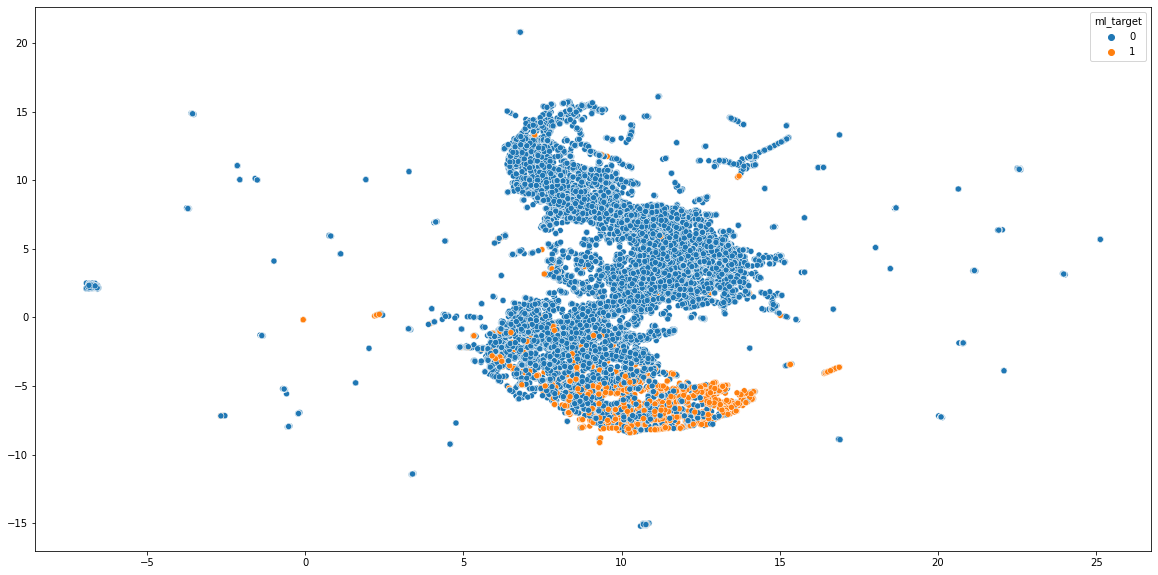

In [10]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
all_indices = get_node_indices(G, np.int64(targets.index))

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])

u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

#Plot the embeddingsembe
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target']) 

# 得到特征


In [11]:
vec_x_sem=semantic_vec
vec_x_syn=syntatic_vec
vec_x_graph=emb[0]
vec_theme=leaf_method_name_vec
vec_y=np.int64(targets['ml_target']) 

# 特征划分

In [12]:

# 数据集切分
print('数据集切分正常')
all_indices = get_node_indices(G, np.int64(targets.index))

train_mask=[]
val_mask=[]
test_mask=[]
for i in all_indices[0]:
    if i in train_indices[0]:
        train_mask.append(True)
    else:
        train_mask.append(False)
    if i in val_indices[0]:
        val_mask.append(True)
    else:
        val_mask.append(False)
    if i in test_indices[0]:
        test_mask.append(True)
    else:
        test_mask.append(False)
train_vec_sem,train_vec_syn, \
train_vec_graph,train_vec_theme,train_lable=splite_data \
    (semantic_vec,syntatic_vec,vec_x_graph,leaf_method_name_vec,
     lable,train_mask)
val_vec_sem,val_vec_syn, \
val_vec_graph,val_vec_theme,val_lable=splite_data \
    (semantic_vec,syntatic_vec,vec_x_graph,leaf_method_name_vec,
     lable,val_mask)
test_vec_sem,test_vec_syn, \
test_vec_graph,test_vec_theme,test_lable=splite_data \
    (semantic_vec,syntatic_vec,vec_x_graph,leaf_method_name_vec,
     lable,test_mask)
train_lable = tf.keras.utils.to_categorical(train_lable, num_classes=2)
test_lable = tf.keras.utils.to_categorical(test_lable, num_classes=2)
val_lable = tf.keras.utils.to_categorical(val_lable, num_classes=2)


数据集切分正常


# 结构+语法+语义+主题


In [ ]:
balance_accuracy_list=[]
precision_list=[]
recall_list=[]
f1_value_list=[]
for i in range(30):
    # 模型构建
    model_graph_4 = get_graph_model_4(len(train_vec_graph[0]),
                                    len(train_vec_syn[0]),
                                    len(train_vec_theme[0]),
                                    len(train_vec_theme[0][0]),num_word,embedding_dim)
    model_graph_4.compile(loss='categorical_crossentropy',
                        optimizer='adam', metrics=['accuracy'])

    # 训练多分枝模型
    # 模型训练
    #录入组合的特征，模型训练
#     save_performance('训练项目：',one_project,'','','')
    history_4 = model_graph_4.fit([np.array(train_vec_graph),
                               np.array(train_vec_syn),np.array(train_vec_theme)],
                                  np.array(train_lable),
                              validation_data=([np.array(val_vec_graph),
                                                np.array(val_vec_syn),
                                                np.array(val_vec_theme)],
                                               np.array(val_lable)),
                              epochs=num_epoch, verbose=2)

#     save_performance('训练结束，开始预测：','','','','')
    # 模型评估
    predict_one_hot = model_graph_4.predict([np.array(test_vec_graph),
                                           np.array(test_vec_syn),
                                          np.array(test_vec_theme)])
    predict_number = [np.argmax(one_hot) for one_hot in predict_one_hot]
    verify_number = [np.argmax(one_hot) for one_hot in test_lable]

    balance_accuracy, precision, recall, f1_value = plot_value(predict_number,verify_number)
    balance_accuracy_list.append(balance_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_value_list.append(f1_value)
ac_ave=np.average(balance_accuracy_list)
ac_var=np.var(balance_accuracy_list)
pr_ave=np.average(precision_list)
pr_var=np.var(precision_list)
re_ave=np.average(recall_list)
re_var=np.var(recall_list)
f1_ave=np.average(f1_value_list)
f1_var=np.var(f1_value_list)
ac_val='%.4f'% ac_ave+'±'+'%.4f'% ac_var
pr_val='%.4f'% pr_ave+'±'+'%.4f'% pr_var
re_val='%.4f'% re_ave+'±'+'%.4f'% re_var
f1_val='%.4f'% f1_ave+'±'+'%.4f'% f1_var
save_performance('主题+语法+语义+gcn',ac_val,pr_val,re_val,f1_val)

Epoch 1/100
331/331 - 14s - loss: 0.1702 - accuracy: 0.9330 - val_loss: 0.1544 - val_accuracy: 0.9402 - 14s/epoch - 43ms/step
Epoch 2/100
331/331 - 6s - loss: 0.1180 - accuracy: 0.9512 - val_loss: 0.1476 - val_accuracy: 0.9461 - 6s/epoch - 17ms/step
Epoch 3/100
331/331 - 6s - loss: 0.1114 - accuracy: 0.9546 - val_loss: 0.1435 - val_accuracy: 0.9470 - 6s/epoch - 17ms/step
Epoch 4/100
331/331 - 6s - loss: 0.1069 - accuracy: 0.9579 - val_loss: 0.1402 - val_accuracy: 0.9473 - 6s/epoch - 17ms/step
Epoch 5/100
331/331 - 6s - loss: 0.1047 - accuracy: 0.9569 - val_loss: 0.1397 - val_accuracy: 0.9487 - 6s/epoch - 17ms/step
Epoch 6/100
331/331 - 6s - loss: 0.1023 - accuracy: 0.9594 - val_loss: 0.1396 - val_accuracy: 0.9481 - 6s/epoch - 17ms/step
Epoch 7/100
331/331 - 6s - loss: 0.1006 - accuracy: 0.9600 - val_loss: 0.1398 - val_accuracy: 0.9492 - 6s/epoch - 17ms/step
Epoch 8/100
331/331 - 6s - loss: 0.0997 - accuracy: 0.9609 - val_loss: 0.1410 - val_accuracy: 0.9507 - 6s/epoch - 17ms/step
Epoch 

Epoch 67/100
331/331 - 6s - loss: 0.0545 - accuracy: 0.9796 - val_loss: 0.1666 - val_accuracy: 0.9563 - 6s/epoch - 18ms/step
Epoch 68/100
331/331 - 6s - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.1558 - val_accuracy: 0.9595 - 6s/epoch - 18ms/step
Epoch 69/100
331/331 - 6s - loss: 0.0529 - accuracy: 0.9796 - val_loss: 0.1597 - val_accuracy: 0.9569 - 6s/epoch - 17ms/step
Epoch 70/100
331/331 - 6s - loss: 0.0555 - accuracy: 0.9786 - val_loss: 0.1587 - val_accuracy: 0.9586 - 6s/epoch - 18ms/step
Epoch 71/100
331/331 - 6s - loss: 0.0526 - accuracy: 0.9803 - val_loss: 0.1573 - val_accuracy: 0.9586 - 6s/epoch - 17ms/step
Epoch 72/100
331/331 - 6s - loss: 0.0517 - accuracy: 0.9802 - val_loss: 0.1667 - val_accuracy: 0.9606 - 6s/epoch - 17ms/step
Epoch 73/100
331/331 - 6s - loss: 0.0515 - accuracy: 0.9789 - val_loss: 0.1595 - val_accuracy: 0.9609 - 6s/epoch - 17ms/step
Epoch 74/100
331/331 - 6s - loss: 0.0525 - accuracy: 0.9802 - val_loss: 0.1686 - val_accuracy: 0.9580 - 6s/epoch - 17ms/step


Epoch 33/100
331/331 - 6s - loss: 0.0701 - accuracy: 0.9715 - val_loss: 0.1383 - val_accuracy: 0.9586 - 6s/epoch - 17ms/step
Epoch 34/100
331/331 - 6s - loss: 0.0695 - accuracy: 0.9725 - val_loss: 0.1488 - val_accuracy: 0.9521 - 6s/epoch - 17ms/step
Epoch 35/100
331/331 - 6s - loss: 0.0700 - accuracy: 0.9738 - val_loss: 0.1413 - val_accuracy: 0.9575 - 6s/epoch - 17ms/step
Epoch 36/100
331/331 - 6s - loss: 0.0679 - accuracy: 0.9738 - val_loss: 0.1420 - val_accuracy: 0.9586 - 6s/epoch - 19ms/step
Epoch 37/100
331/331 - 6s - loss: 0.0682 - accuracy: 0.9733 - val_loss: 0.1359 - val_accuracy: 0.9549 - 6s/epoch - 17ms/step
Epoch 38/100
331/331 - 6s - loss: 0.0675 - accuracy: 0.9731 - val_loss: 0.1446 - val_accuracy: 0.9575 - 6s/epoch - 17ms/step
Epoch 39/100
331/331 - 6s - loss: 0.0692 - accuracy: 0.9732 - val_loss: 0.1376 - val_accuracy: 0.9580 - 6s/epoch - 17ms/step
Epoch 40/100
331/331 - 6s - loss: 0.0680 - accuracy: 0.9735 - val_loss: 0.1427 - val_accuracy: 0.9549 - 6s/epoch - 17ms/step


Epoch 99/100
331/331 - 6s - loss: 0.0493 - accuracy: 0.9800 - val_loss: 0.1638 - val_accuracy: 0.9569 - 6s/epoch - 18ms/step
Epoch 100/100
331/331 - 6s - loss: 0.0477 - accuracy: 0.9819 - val_loss: 0.1637 - val_accuracy: 0.9552 - 6s/epoch - 18ms/step
Epoch 1/100
331/331 - 14s - loss: 0.1813 - accuracy: 0.9257 - val_loss: 0.1557 - val_accuracy: 0.9368 - 14s/epoch - 41ms/step
Epoch 2/100
331/331 - 6s - loss: 0.1191 - accuracy: 0.9499 - val_loss: 0.1498 - val_accuracy: 0.9450 - 6s/epoch - 17ms/step
Epoch 3/100
331/331 - 6s - loss: 0.1118 - accuracy: 0.9548 - val_loss: 0.1465 - val_accuracy: 0.9430 - 6s/epoch - 17ms/step
Epoch 4/100
331/331 - 6s - loss: 0.1066 - accuracy: 0.9586 - val_loss: 0.1458 - val_accuracy: 0.9453 - 6s/epoch - 17ms/step
Epoch 5/100
331/331 - 6s - loss: 0.1047 - accuracy: 0.9596 - val_loss: 0.1410 - val_accuracy: 0.9470 - 6s/epoch - 17ms/step
Epoch 6/100
331/331 - 6s - loss: 0.1012 - accuracy: 0.9581 - val_loss: 0.1378 - val_accuracy: 0.9498 - 6s/epoch - 17ms/step
Epo

Epoch 65/100
331/331 - 6s - loss: 0.0551 - accuracy: 0.9799 - val_loss: 0.1526 - val_accuracy: 0.9561 - 6s/epoch - 17ms/step
Epoch 66/100
331/331 - 6s - loss: 0.0568 - accuracy: 0.9791 - val_loss: 0.1523 - val_accuracy: 0.9572 - 6s/epoch - 17ms/step
Epoch 67/100
331/331 - 6s - loss: 0.0554 - accuracy: 0.9800 - val_loss: 0.1516 - val_accuracy: 0.9569 - 6s/epoch - 17ms/step
Epoch 68/100
331/331 - 6s - loss: 0.0553 - accuracy: 0.9805 - val_loss: 0.1549 - val_accuracy: 0.9546 - 6s/epoch - 17ms/step
Epoch 69/100
331/331 - 6s - loss: 0.0548 - accuracy: 0.9792 - val_loss: 0.1506 - val_accuracy: 0.9572 - 6s/epoch - 17ms/step
Epoch 70/100
331/331 - 6s - loss: 0.0538 - accuracy: 0.9794 - val_loss: 0.1496 - val_accuracy: 0.9563 - 6s/epoch - 17ms/step
Epoch 71/100
331/331 - 6s - loss: 0.0539 - accuracy: 0.9801 - val_loss: 0.1502 - val_accuracy: 0.9583 - 6s/epoch - 17ms/step
Epoch 72/100
331/331 - 6s - loss: 0.0544 - accuracy: 0.9792 - val_loss: 0.1485 - val_accuracy: 0.9583 - 6s/epoch - 17ms/step


Epoch 31/100
331/331 - 6s - loss: 0.0649 - accuracy: 0.9753 - val_loss: 0.1355 - val_accuracy: 0.9569 - 6s/epoch - 19ms/step
Epoch 32/100
331/331 - 6s - loss: 0.0651 - accuracy: 0.9740 - val_loss: 0.1405 - val_accuracy: 0.9563 - 6s/epoch - 18ms/step
Epoch 33/100
331/331 - 6s - loss: 0.0650 - accuracy: 0.9750 - val_loss: 0.1406 - val_accuracy: 0.9552 - 6s/epoch - 18ms/step
Epoch 34/100
331/331 - 6s - loss: 0.0633 - accuracy: 0.9755 - val_loss: 0.1443 - val_accuracy: 0.9527 - 6s/epoch - 18ms/step
Epoch 35/100
331/331 - 6s - loss: 0.0625 - accuracy: 0.9758 - val_loss: 0.1500 - val_accuracy: 0.9501 - 6s/epoch - 18ms/step
Epoch 36/100
331/331 - 6s - loss: 0.0632 - accuracy: 0.9762 - val_loss: 0.1464 - val_accuracy: 0.9558 - 6s/epoch - 18ms/step
Epoch 37/100
331/331 - 6s - loss: 0.0622 - accuracy: 0.9763 - val_loss: 0.1390 - val_accuracy: 0.9561 - 6s/epoch - 18ms/step
Epoch 38/100
331/331 - 6s - loss: 0.0621 - accuracy: 0.9772 - val_loss: 0.1357 - val_accuracy: 0.9575 - 6s/epoch - 18ms/step


Epoch 97/100
331/331 - 6s - loss: 0.0442 - accuracy: 0.9843 - val_loss: 0.1731 - val_accuracy: 0.9549 - 6s/epoch - 18ms/step
Epoch 98/100
331/331 - 6s - loss: 0.0454 - accuracy: 0.9822 - val_loss: 0.1798 - val_accuracy: 0.9572 - 6s/epoch - 18ms/step
Epoch 99/100
331/331 - 6s - loss: 0.0463 - accuracy: 0.9824 - val_loss: 0.1725 - val_accuracy: 0.9558 - 6s/epoch - 18ms/step
Epoch 100/100
331/331 - 6s - loss: 0.0449 - accuracy: 0.9817 - val_loss: 0.1742 - val_accuracy: 0.9546 - 6s/epoch - 19ms/step
Epoch 1/100
331/331 - 15s - loss: 0.1719 - accuracy: 0.9344 - val_loss: 0.1534 - val_accuracy: 0.9382 - 15s/epoch - 45ms/step
Epoch 2/100
331/331 - 6s - loss: 0.1175 - accuracy: 0.9515 - val_loss: 0.1479 - val_accuracy: 0.9441 - 6s/epoch - 18ms/step
Epoch 3/100
331/331 - 6s - loss: 0.1094 - accuracy: 0.9567 - val_loss: 0.1459 - val_accuracy: 0.9439 - 6s/epoch - 18ms/step
Epoch 4/100
331/331 - 6s - loss: 0.1047 - accuracy: 0.9586 - val_loss: 0.1416 - val_accuracy: 0.9467 - 6s/epoch - 18ms/step
E

Epoch 63/100
331/331 - 6s - loss: 0.0639 - accuracy: 0.9744 - val_loss: 0.1498 - val_accuracy: 0.9549 - 6s/epoch - 18ms/step
Epoch 64/100
331/331 - 6s - loss: 0.0631 - accuracy: 0.9755 - val_loss: 0.1510 - val_accuracy: 0.9552 - 6s/epoch - 18ms/step
Epoch 65/100
331/331 - 6s - loss: 0.0624 - accuracy: 0.9756 - val_loss: 0.1580 - val_accuracy: 0.9586 - 6s/epoch - 18ms/step
Epoch 66/100
331/331 - 6s - loss: 0.0603 - accuracy: 0.9768 - val_loss: 0.1470 - val_accuracy: 0.9549 - 6s/epoch - 18ms/step
Epoch 67/100
331/331 - 6s - loss: 0.0632 - accuracy: 0.9766 - val_loss: 0.1527 - val_accuracy: 0.9541 - 6s/epoch - 19ms/step
Epoch 68/100
331/331 - 6s - loss: 0.0606 - accuracy: 0.9757 - val_loss: 0.1527 - val_accuracy: 0.9572 - 6s/epoch - 18ms/step
Epoch 69/100
331/331 - 6s - loss: 0.0616 - accuracy: 0.9768 - val_loss: 0.1604 - val_accuracy: 0.9597 - 6s/epoch - 18ms/step
Epoch 70/100
331/331 - 6s - loss: 0.0623 - accuracy: 0.9760 - val_loss: 0.1487 - val_accuracy: 0.9597 - 6s/epoch - 18ms/step


Epoch 29/100
331/331 - 6s - loss: 0.0711 - accuracy: 0.9730 - val_loss: 0.1392 - val_accuracy: 0.9544 - 6s/epoch - 19ms/step
Epoch 30/100
331/331 - 6s - loss: 0.0705 - accuracy: 0.9735 - val_loss: 0.1437 - val_accuracy: 0.9563 - 6s/epoch - 19ms/step
Epoch 31/100
331/331 - 6s - loss: 0.0704 - accuracy: 0.9723 - val_loss: 0.1374 - val_accuracy: 0.9569 - 6s/epoch - 19ms/step
Epoch 32/100
331/331 - 6s - loss: 0.0691 - accuracy: 0.9740 - val_loss: 0.1380 - val_accuracy: 0.9575 - 6s/epoch - 19ms/step
Epoch 33/100
331/331 - 7s - loss: 0.0688 - accuracy: 0.9751 - val_loss: 0.1352 - val_accuracy: 0.9558 - 7s/epoch - 21ms/step
Epoch 34/100
331/331 - 6s - loss: 0.0676 - accuracy: 0.9753 - val_loss: 0.1348 - val_accuracy: 0.9572 - 6s/epoch - 19ms/step
Epoch 35/100
331/331 - 6s - loss: 0.0680 - accuracy: 0.9754 - val_loss: 0.1365 - val_accuracy: 0.9578 - 6s/epoch - 19ms/step
Epoch 36/100
331/331 - 6s - loss: 0.0673 - accuracy: 0.9754 - val_loss: 0.1444 - val_accuracy: 0.9575 - 6s/epoch - 19ms/step


Epoch 95/100
331/331 - 6s - loss: 0.0470 - accuracy: 0.9828 - val_loss: 0.1630 - val_accuracy: 0.9566 - 6s/epoch - 19ms/step
Epoch 96/100
331/331 - 6s - loss: 0.0476 - accuracy: 0.9823 - val_loss: 0.1633 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step
Epoch 97/100
331/331 - 6s - loss: 0.0454 - accuracy: 0.9820 - val_loss: 0.1613 - val_accuracy: 0.9544 - 6s/epoch - 19ms/step
Epoch 98/100
331/331 - 6s - loss: 0.0462 - accuracy: 0.9823 - val_loss: 0.1629 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step
Epoch 99/100
331/331 - 6s - loss: 0.0444 - accuracy: 0.9830 - val_loss: 0.1649 - val_accuracy: 0.9544 - 6s/epoch - 19ms/step
Epoch 100/100
331/331 - 7s - loss: 0.0471 - accuracy: 0.9824 - val_loss: 0.1602 - val_accuracy: 0.9544 - 7s/epoch - 20ms/step
Epoch 1/100
331/331 - 15s - loss: 0.1884 - accuracy: 0.9192 - val_loss: 0.1520 - val_accuracy: 0.9388 - 15s/epoch - 47ms/step
Epoch 2/100
331/331 - 6s - loss: 0.1185 - accuracy: 0.9510 - val_loss: 0.1461 - val_accuracy: 0.9436 - 6s/epoch - 19ms/step

Epoch 61/100
331/331 - 6s - loss: 0.0594 - accuracy: 0.9785 - val_loss: 0.1496 - val_accuracy: 0.9600 - 6s/epoch - 19ms/step
Epoch 62/100
331/331 - 6s - loss: 0.0574 - accuracy: 0.9784 - val_loss: 0.1495 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step
Epoch 63/100
331/331 - 6s - loss: 0.0579 - accuracy: 0.9783 - val_loss: 0.1507 - val_accuracy: 0.9572 - 6s/epoch - 19ms/step
Epoch 64/100
331/331 - 7s - loss: 0.0591 - accuracy: 0.9774 - val_loss: 0.1495 - val_accuracy: 0.9592 - 7s/epoch - 21ms/step
Epoch 65/100
331/331 - 6s - loss: 0.0588 - accuracy: 0.9778 - val_loss: 0.1557 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step
Epoch 66/100
331/331 - 6s - loss: 0.0562 - accuracy: 0.9788 - val_loss: 0.1518 - val_accuracy: 0.9580 - 6s/epoch - 19ms/step
Epoch 67/100
331/331 - 6s - loss: 0.0569 - accuracy: 0.9792 - val_loss: 0.1486 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step
Epoch 68/100
331/331 - 6s - loss: 0.0564 - accuracy: 0.9797 - val_loss: 0.1507 - val_accuracy: 0.9555 - 6s/epoch - 19ms/step


Epoch 27/100
331/331 - 7s - loss: 0.0692 - accuracy: 0.9726 - val_loss: 0.1347 - val_accuracy: 0.9575 - 7s/epoch - 21ms/step
Epoch 28/100
331/331 - 7s - loss: 0.0674 - accuracy: 0.9750 - val_loss: 0.1347 - val_accuracy: 0.9592 - 7s/epoch - 21ms/step
Epoch 29/100
331/331 - 7s - loss: 0.0671 - accuracy: 0.9758 - val_loss: 0.1320 - val_accuracy: 0.9614 - 7s/epoch - 21ms/step
Epoch 30/100
331/331 - 7s - loss: 0.0658 - accuracy: 0.9750 - val_loss: 0.1364 - val_accuracy: 0.9600 - 7s/epoch - 21ms/step
Epoch 31/100
331/331 - 7s - loss: 0.0666 - accuracy: 0.9759 - val_loss: 0.1343 - val_accuracy: 0.9563 - 7s/epoch - 21ms/step
Epoch 32/100
331/331 - 7s - loss: 0.0651 - accuracy: 0.9742 - val_loss: 0.1337 - val_accuracy: 0.9595 - 7s/epoch - 21ms/step
Epoch 33/100
331/331 - 7s - loss: 0.0657 - accuracy: 0.9744 - val_loss: 0.1363 - val_accuracy: 0.9589 - 7s/epoch - 22ms/step
Epoch 34/100
331/331 - 7s - loss: 0.0633 - accuracy: 0.9753 - val_loss: 0.1473 - val_accuracy: 0.9597 - 7s/epoch - 21ms/step


Epoch 93/100
331/331 - 7s - loss: 0.0477 - accuracy: 0.9816 - val_loss: 0.1567 - val_accuracy: 0.9561 - 7s/epoch - 20ms/step
Epoch 94/100
331/331 - 6s - loss: 0.0463 - accuracy: 0.9822 - val_loss: 0.1672 - val_accuracy: 0.9566 - 6s/epoch - 20ms/step
Epoch 95/100
331/331 - 7s - loss: 0.0461 - accuracy: 0.9825 - val_loss: 0.1619 - val_accuracy: 0.9563 - 7s/epoch - 21ms/step
Epoch 96/100
331/331 - 7s - loss: 0.0451 - accuracy: 0.9826 - val_loss: 0.1543 - val_accuracy: 0.9561 - 7s/epoch - 20ms/step
Epoch 97/100
331/331 - 6s - loss: 0.0453 - accuracy: 0.9823 - val_loss: 0.1591 - val_accuracy: 0.9569 - 6s/epoch - 20ms/step
Epoch 98/100
331/331 - 7s - loss: 0.0442 - accuracy: 0.9829 - val_loss: 0.1661 - val_accuracy: 0.9589 - 7s/epoch - 20ms/step
Epoch 99/100
331/331 - 7s - loss: 0.0450 - accuracy: 0.9836 - val_loss: 0.1611 - val_accuracy: 0.9569 - 7s/epoch - 20ms/step
Epoch 100/100
331/331 - 7s - loss: 0.0438 - accuracy: 0.9827 - val_loss: 0.1639 - val_accuracy: 0.9580 - 7s/epoch - 20ms/step

Epoch 59/100
331/331 - 7s - loss: 0.0551 - accuracy: 0.9793 - val_loss: 0.1531 - val_accuracy: 0.9546 - 7s/epoch - 20ms/step
Epoch 60/100
331/331 - 7s - loss: 0.0551 - accuracy: 0.9790 - val_loss: 0.1543 - val_accuracy: 0.9597 - 7s/epoch - 22ms/step
Epoch 61/100
331/331 - 8s - loss: 0.0547 - accuracy: 0.9781 - val_loss: 0.1548 - val_accuracy: 0.9544 - 8s/epoch - 25ms/step
Epoch 62/100
331/331 - 8s - loss: 0.0548 - accuracy: 0.9783 - val_loss: 0.1497 - val_accuracy: 0.9575 - 8s/epoch - 24ms/step
Epoch 63/100
331/331 - 7s - loss: 0.0545 - accuracy: 0.9779 - val_loss: 0.1526 - val_accuracy: 0.9569 - 7s/epoch - 22ms/step
Epoch 64/100
331/331 - 7s - loss: 0.0528 - accuracy: 0.9812 - val_loss: 0.1511 - val_accuracy: 0.9572 - 7s/epoch - 21ms/step
Epoch 65/100
331/331 - 7s - loss: 0.0533 - accuracy: 0.9785 - val_loss: 0.1570 - val_accuracy: 0.9589 - 7s/epoch - 21ms/step
Epoch 66/100
331/331 - 7s - loss: 0.0525 - accuracy: 0.9800 - val_loss: 0.1581 - val_accuracy: 0.9592 - 7s/epoch - 21ms/step


Epoch 25/100
331/331 - 7s - loss: 0.0743 - accuracy: 0.9704 - val_loss: 0.1333 - val_accuracy: 0.9529 - 7s/epoch - 21ms/step
Epoch 26/100
331/331 - 8s - loss: 0.0741 - accuracy: 0.9716 - val_loss: 0.1433 - val_accuracy: 0.9521 - 8s/epoch - 23ms/step
Epoch 27/100
331/331 - 8s - loss: 0.0737 - accuracy: 0.9718 - val_loss: 0.1383 - val_accuracy: 0.9521 - 8s/epoch - 24ms/step
Epoch 28/100
331/331 - 7s - loss: 0.0712 - accuracy: 0.9720 - val_loss: 0.1372 - val_accuracy: 0.9524 - 7s/epoch - 23ms/step
Epoch 29/100
331/331 - 7s - loss: 0.0732 - accuracy: 0.9706 - val_loss: 0.1411 - val_accuracy: 0.9512 - 7s/epoch - 21ms/step
Epoch 30/100
331/331 - 8s - loss: 0.0725 - accuracy: 0.9711 - val_loss: 0.1454 - val_accuracy: 0.9566 - 8s/epoch - 23ms/step
Epoch 31/100
331/331 - 7s - loss: 0.0721 - accuracy: 0.9714 - val_loss: 0.1436 - val_accuracy: 0.9575 - 7s/epoch - 21ms/step
Epoch 32/100
331/331 - 7s - loss: 0.0713 - accuracy: 0.9717 - val_loss: 0.1401 - val_accuracy: 0.9535 - 7s/epoch - 20ms/step


Epoch 91/100
331/331 - 7s - loss: 0.0514 - accuracy: 0.9809 - val_loss: 0.1619 - val_accuracy: 0.9558 - 7s/epoch - 22ms/step
Epoch 92/100
331/331 - 7s - loss: 0.0517 - accuracy: 0.9802 - val_loss: 0.1633 - val_accuracy: 0.9558 - 7s/epoch - 21ms/step
Epoch 93/100
331/331 - 7s - loss: 0.0506 - accuracy: 0.9803 - val_loss: 0.1606 - val_accuracy: 0.9558 - 7s/epoch - 21ms/step
Epoch 94/100
331/331 - 7s - loss: 0.0511 - accuracy: 0.9809 - val_loss: 0.1595 - val_accuracy: 0.9566 - 7s/epoch - 20ms/step
Epoch 95/100
331/331 - 7s - loss: 0.0502 - accuracy: 0.9802 - val_loss: 0.1693 - val_accuracy: 0.9552 - 7s/epoch - 20ms/step
Epoch 96/100
331/331 - 7s - loss: 0.0510 - accuracy: 0.9798 - val_loss: 0.1626 - val_accuracy: 0.9558 - 7s/epoch - 20ms/step
Epoch 97/100
331/331 - 7s - loss: 0.0499 - accuracy: 0.9806 - val_loss: 0.1645 - val_accuracy: 0.9575 - 7s/epoch - 20ms/step
Epoch 98/100
331/331 - 7s - loss: 0.0495 - accuracy: 0.9816 - val_loss: 0.1673 - val_accuracy: 0.9575 - 7s/epoch - 20ms/step


331/331 - 10s - loss: 0.0588 - accuracy: 0.9784 - val_loss: 0.1481 - val_accuracy: 0.9544 - 10s/epoch - 30ms/step
Epoch 57/100
331/331 - 9s - loss: 0.0592 - accuracy: 0.9777 - val_loss: 0.1460 - val_accuracy: 0.9532 - 9s/epoch - 29ms/step
Epoch 58/100
331/331 - 11s - loss: 0.0606 - accuracy: 0.9777 - val_loss: 0.1452 - val_accuracy: 0.9552 - 11s/epoch - 32ms/step
Epoch 59/100
331/331 - 11s - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.1545 - val_accuracy: 0.9569 - 11s/epoch - 33ms/step
Epoch 60/100
331/331 - 10s - loss: 0.0585 - accuracy: 0.9788 - val_loss: 0.1468 - val_accuracy: 0.9535 - 10s/epoch - 31ms/step
Epoch 61/100
331/331 - 10s - loss: 0.0583 - accuracy: 0.9782 - val_loss: 0.1519 - val_accuracy: 0.9507 - 10s/epoch - 32ms/step
Epoch 62/100
331/331 - 10s - loss: 0.0584 - accuracy: 0.9783 - val_loss: 0.1524 - val_accuracy: 0.9552 - 10s/epoch - 31ms/step
Epoch 63/100
331/331 - 10s - loss: 0.0565 - accuracy: 0.9799 - val_loss: 0.1521 - val_accuracy: 0.9563 - 10s/epoch - 31ms/step

Epoch 21/100
331/331 - 9s - loss: 0.0724 - accuracy: 0.9726 - val_loss: 0.1364 - val_accuracy: 0.9541 - 9s/epoch - 26ms/step
Epoch 22/100
331/331 - 8s - loss: 0.0715 - accuracy: 0.9716 - val_loss: 0.1329 - val_accuracy: 0.9572 - 8s/epoch - 25ms/step
Epoch 23/100
331/331 - 8s - loss: 0.0700 - accuracy: 0.9720 - val_loss: 0.1397 - val_accuracy: 0.9521 - 8s/epoch - 25ms/step
Epoch 24/100
331/331 - 9s - loss: 0.0707 - accuracy: 0.9738 - val_loss: 0.1373 - val_accuracy: 0.9532 - 9s/epoch - 27ms/step
Epoch 25/100
331/331 - 9s - loss: 0.0690 - accuracy: 0.9745 - val_loss: 0.1338 - val_accuracy: 0.9552 - 9s/epoch - 26ms/step
Epoch 26/100
331/331 - 9s - loss: 0.0673 - accuracy: 0.9743 - val_loss: 0.1416 - val_accuracy: 0.9524 - 9s/epoch - 27ms/step
Epoch 27/100
331/331 - 9s - loss: 0.0682 - accuracy: 0.9745 - val_loss: 0.1383 - val_accuracy: 0.9572 - 9s/epoch - 28ms/step
Epoch 28/100
331/331 - 9s - loss: 0.0673 - accuracy: 0.9745 - val_loss: 0.1361 - val_accuracy: 0.9575 - 9s/epoch - 26ms/step


Epoch 87/100
331/331 - 8s - loss: 0.0469 - accuracy: 0.9820 - val_loss: 0.1763 - val_accuracy: 0.9566 - 8s/epoch - 24ms/step
Epoch 88/100
331/331 - 8s - loss: 0.0476 - accuracy: 0.9817 - val_loss: 0.1739 - val_accuracy: 0.9575 - 8s/epoch - 23ms/step
Epoch 89/100
331/331 - 8s - loss: 0.0451 - accuracy: 0.9834 - val_loss: 0.1758 - val_accuracy: 0.9597 - 8s/epoch - 23ms/step
Epoch 90/100
331/331 - 8s - loss: 0.0453 - accuracy: 0.9821 - val_loss: 0.1758 - val_accuracy: 0.9603 - 8s/epoch - 23ms/step
Epoch 91/100
331/331 - 8s - loss: 0.0466 - accuracy: 0.9810 - val_loss: 0.1746 - val_accuracy: 0.9580 - 8s/epoch - 23ms/step
Epoch 92/100
331/331 - 8s - loss: 0.0473 - accuracy: 0.9818 - val_loss: 0.1812 - val_accuracy: 0.9569 - 8s/epoch - 23ms/step
Epoch 93/100
331/331 - 8s - loss: 0.0457 - accuracy: 0.9830 - val_loss: 0.1712 - val_accuracy: 0.9595 - 8s/epoch - 24ms/step
Epoch 94/100
331/331 - 7s - loss: 0.0454 - accuracy: 0.9824 - val_loss: 0.1804 - val_accuracy: 0.9603 - 7s/epoch - 23ms/step


Epoch 53/100
331/331 - 8s - loss: 0.0603 - accuracy: 0.9761 - val_loss: 0.1519 - val_accuracy: 0.9558 - 8s/epoch - 25ms/step
Epoch 54/100
331/331 - 8s - loss: 0.0603 - accuracy: 0.9764 - val_loss: 0.1474 - val_accuracy: 0.9569 - 8s/epoch - 25ms/step
Epoch 55/100
331/331 - 8s - loss: 0.0573 - accuracy: 0.9777 - val_loss: 0.1466 - val_accuracy: 0.9566 - 8s/epoch - 24ms/step
Epoch 56/100
331/331 - 8s - loss: 0.0580 - accuracy: 0.9768 - val_loss: 0.1529 - val_accuracy: 0.9549 - 8s/epoch - 25ms/step
Epoch 57/100
331/331 - 8s - loss: 0.0610 - accuracy: 0.9768 - val_loss: 0.1462 - val_accuracy: 0.9544 - 8s/epoch - 26ms/step
Epoch 58/100
331/331 - 9s - loss: 0.0589 - accuracy: 0.9768 - val_loss: 0.1486 - val_accuracy: 0.9561 - 9s/epoch - 26ms/step
Epoch 59/100
331/331 - 8s - loss: 0.0568 - accuracy: 0.9776 - val_loss: 0.1559 - val_accuracy: 0.9541 - 8s/epoch - 24ms/step
Epoch 60/100
331/331 - 8s - loss: 0.0576 - accuracy: 0.9776 - val_loss: 0.1548 - val_accuracy: 0.9524 - 8s/epoch - 23ms/step


Epoch 19/100
331/331 - 10s - loss: 0.0757 - accuracy: 0.9699 - val_loss: 0.1446 - val_accuracy: 0.9470 - 10s/epoch - 31ms/step
Epoch 20/100
331/331 - 9s - loss: 0.0760 - accuracy: 0.9694 - val_loss: 0.1379 - val_accuracy: 0.9504 - 9s/epoch - 28ms/step
Epoch 21/100
331/331 - 9s - loss: 0.0745 - accuracy: 0.9686 - val_loss: 0.1432 - val_accuracy: 0.9558 - 9s/epoch - 28ms/step
Epoch 22/100
331/331 - 9s - loss: 0.0742 - accuracy: 0.9701 - val_loss: 0.1384 - val_accuracy: 0.9509 - 9s/epoch - 28ms/step
Epoch 23/100
331/331 - 10s - loss: 0.0740 - accuracy: 0.9701 - val_loss: 0.1370 - val_accuracy: 0.9558 - 10s/epoch - 30ms/step
Epoch 24/100
331/331 - 10s - loss: 0.0729 - accuracy: 0.9709 - val_loss: 0.1415 - val_accuracy: 0.9569 - 10s/epoch - 31ms/step
Epoch 25/100
331/331 - 10s - loss: 0.0720 - accuracy: 0.9704 - val_loss: 0.1373 - val_accuracy: 0.9561 - 10s/epoch - 30ms/step
Epoch 26/100
331/331 - 10s - loss: 0.0708 - accuracy: 0.9716 - val_loss: 0.1398 - val_accuracy: 0.9572 - 10s/epoch - 

Epoch 84/100
331/331 - 12s - loss: 0.0548 - accuracy: 0.9776 - val_loss: 0.1660 - val_accuracy: 0.9566 - 12s/epoch - 36ms/step
Epoch 85/100
331/331 - 10s - loss: 0.0527 - accuracy: 0.9780 - val_loss: 0.1682 - val_accuracy: 0.9569 - 10s/epoch - 32ms/step
Epoch 86/100
331/331 - 11s - loss: 0.0524 - accuracy: 0.9784 - val_loss: 0.1671 - val_accuracy: 0.9509 - 11s/epoch - 35ms/step
Epoch 87/100
331/331 - 10s - loss: 0.0527 - accuracy: 0.9791 - val_loss: 0.1582 - val_accuracy: 0.9535 - 10s/epoch - 31ms/step
Epoch 88/100
331/331 - 10s - loss: 0.0522 - accuracy: 0.9790 - val_loss: 0.1644 - val_accuracy: 0.9569 - 10s/epoch - 29ms/step
Epoch 89/100
331/331 - 10s - loss: 0.0510 - accuracy: 0.9782 - val_loss: 0.1635 - val_accuracy: 0.9535 - 10s/epoch - 30ms/step
Epoch 90/100
331/331 - 11s - loss: 0.0528 - accuracy: 0.9793 - val_loss: 0.1678 - val_accuracy: 0.9532 - 11s/epoch - 34ms/step
Epoch 91/100
331/331 - 9s - loss: 0.0513 - accuracy: 0.9788 - val_loss: 0.1623 - val_accuracy: 0.9527 - 9s/epoc

Epoch 50/100
331/331 - 9s - loss: 0.0620 - accuracy: 0.9771 - val_loss: 0.1487 - val_accuracy: 0.9538 - 9s/epoch - 26ms/step
Epoch 51/100
331/331 - 9s - loss: 0.0602 - accuracy: 0.9783 - val_loss: 0.1535 - val_accuracy: 0.9572 - 9s/epoch - 26ms/step
Epoch 52/100
331/331 - 9s - loss: 0.0605 - accuracy: 0.9778 - val_loss: 0.1513 - val_accuracy: 0.9501 - 9s/epoch - 28ms/step
Epoch 53/100
331/331 - 9s - loss: 0.0599 - accuracy: 0.9779 - val_loss: 0.1519 - val_accuracy: 0.9561 - 9s/epoch - 27ms/step
Epoch 54/100
331/331 - 8s - loss: 0.0595 - accuracy: 0.9785 - val_loss: 0.1590 - val_accuracy: 0.9561 - 8s/epoch - 26ms/step
Epoch 55/100
331/331 - 9s - loss: 0.0585 - accuracy: 0.9786 - val_loss: 0.1555 - val_accuracy: 0.9546 - 9s/epoch - 26ms/step
Epoch 56/100
331/331 - 9s - loss: 0.0600 - accuracy: 0.9768 - val_loss: 0.1511 - val_accuracy: 0.9535 - 9s/epoch - 29ms/step
Epoch 57/100
331/331 - 9s - loss: 0.0606 - accuracy: 0.9768 - val_loss: 0.1508 - val_accuracy: 0.9535 - 9s/epoch - 28ms/step


Epoch 16/100
331/331 - 9s - loss: 0.0814 - accuracy: 0.9682 - val_loss: 0.1369 - val_accuracy: 0.9504 - 9s/epoch - 27ms/step
Epoch 17/100
331/331 - 9s - loss: 0.0801 - accuracy: 0.9692 - val_loss: 0.1420 - val_accuracy: 0.9552 - 9s/epoch - 27ms/step
Epoch 18/100
331/331 - 9s - loss: 0.0796 - accuracy: 0.9689 - val_loss: 0.1372 - val_accuracy: 0.9549 - 9s/epoch - 26ms/step
Epoch 19/100
331/331 - 8s - loss: 0.0783 - accuracy: 0.9691 - val_loss: 0.1367 - val_accuracy: 0.9492 - 8s/epoch - 25ms/step
Epoch 20/100
331/331 - 9s - loss: 0.0780 - accuracy: 0.9702 - val_loss: 0.1360 - val_accuracy: 0.9575 - 9s/epoch - 28ms/step
Epoch 21/100
331/331 - 8s - loss: 0.0755 - accuracy: 0.9721 - val_loss: 0.1554 - val_accuracy: 0.9433 - 8s/epoch - 25ms/step
Epoch 22/100
331/331 - 9s - loss: 0.0780 - accuracy: 0.9690 - val_loss: 0.1431 - val_accuracy: 0.9456 - 9s/epoch - 26ms/step
Epoch 23/100
331/331 - 8s - loss: 0.0753 - accuracy: 0.9700 - val_loss: 0.1388 - val_accuracy: 0.9524 - 8s/epoch - 25ms/step


Epoch 82/100
331/331 - 8s - loss: 0.0540 - accuracy: 0.9768 - val_loss: 0.1705 - val_accuracy: 0.9589 - 8s/epoch - 23ms/step
Epoch 83/100
331/331 - 7s - loss: 0.0530 - accuracy: 0.9785 - val_loss: 0.1674 - val_accuracy: 0.9586 - 7s/epoch - 23ms/step
Epoch 84/100
331/331 - 7s - loss: 0.0533 - accuracy: 0.9779 - val_loss: 0.1663 - val_accuracy: 0.9606 - 7s/epoch - 22ms/step
Epoch 85/100
331/331 - 8s - loss: 0.0536 - accuracy: 0.9788 - val_loss: 0.1616 - val_accuracy: 0.9589 - 8s/epoch - 23ms/step
Epoch 86/100
331/331 - 8s - loss: 0.0523 - accuracy: 0.9789 - val_loss: 0.1794 - val_accuracy: 0.9558 - 8s/epoch - 23ms/step
Epoch 87/100
331/331 - 7s - loss: 0.0521 - accuracy: 0.9782 - val_loss: 0.1711 - val_accuracy: 0.9597 - 7s/epoch - 23ms/step
Epoch 88/100
331/331 - 7s - loss: 0.0527 - accuracy: 0.9788 - val_loss: 0.1712 - val_accuracy: 0.9555 - 7s/epoch - 23ms/step
Epoch 89/100
331/331 - 8s - loss: 0.0528 - accuracy: 0.9781 - val_loss: 0.1726 - val_accuracy: 0.9595 - 8s/epoch - 23ms/step


Epoch 48/100
331/331 - 8s - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1552 - val_accuracy: 0.9552 - 8s/epoch - 25ms/step
Epoch 49/100
331/331 - 8s - loss: 0.0598 - accuracy: 0.9768 - val_loss: 0.1519 - val_accuracy: 0.9552 - 8s/epoch - 24ms/step
Epoch 50/100
331/331 - 8s - loss: 0.0606 - accuracy: 0.9766 - val_loss: 0.1578 - val_accuracy: 0.9546 - 8s/epoch - 24ms/step
Epoch 51/100
331/331 - 9s - loss: 0.0599 - accuracy: 0.9764 - val_loss: 0.1553 - val_accuracy: 0.9544 - 9s/epoch - 28ms/step
Epoch 52/100
331/331 - 9s - loss: 0.0610 - accuracy: 0.9767 - val_loss: 0.1572 - val_accuracy: 0.9524 - 9s/epoch - 26ms/step
Epoch 53/100
331/331 - 8s - loss: 0.0598 - accuracy: 0.9777 - val_loss: 0.1611 - val_accuracy: 0.9546 - 8s/epoch - 23ms/step
Epoch 54/100
331/331 - 8s - loss: 0.0595 - accuracy: 0.9775 - val_loss: 0.1554 - val_accuracy: 0.9572 - 8s/epoch - 25ms/step
Epoch 55/100
331/331 - 8s - loss: 0.0590 - accuracy: 0.9770 - val_loss: 0.1583 - val_accuracy: 0.9563 - 8s/epoch - 24ms/step


Epoch 14/100
331/331 - 8s - loss: 0.0772 - accuracy: 0.9683 - val_loss: 0.1324 - val_accuracy: 0.9541 - 8s/epoch - 24ms/step
Epoch 15/100
331/331 - 8s - loss: 0.0763 - accuracy: 0.9699 - val_loss: 0.1335 - val_accuracy: 0.9535 - 8s/epoch - 24ms/step
Epoch 16/100
331/331 - 8s - loss: 0.0748 - accuracy: 0.9709 - val_loss: 0.1315 - val_accuracy: 0.9578 - 8s/epoch - 24ms/step
Epoch 17/100
331/331 - 8s - loss: 0.0731 - accuracy: 0.9699 - val_loss: 0.1318 - val_accuracy: 0.9541 - 8s/epoch - 25ms/step
Epoch 18/100
331/331 - 8s - loss: 0.0731 - accuracy: 0.9714 - val_loss: 0.1337 - val_accuracy: 0.9546 - 8s/epoch - 24ms/step
Epoch 19/100
331/331 - 8s - loss: 0.0718 - accuracy: 0.9716 - val_loss: 0.1346 - val_accuracy: 0.9558 - 8s/epoch - 25ms/step
Epoch 20/100
331/331 - 8s - loss: 0.0704 - accuracy: 0.9734 - val_loss: 0.1361 - val_accuracy: 0.9566 - 8s/epoch - 23ms/step
Epoch 21/100
331/331 - 8s - loss: 0.0691 - accuracy: 0.9733 - val_loss: 0.1364 - val_accuracy: 0.9580 - 8s/epoch - 24ms/step


Epoch 80/100
331/331 - 8s - loss: 0.0464 - accuracy: 0.9809 - val_loss: 0.1592 - val_accuracy: 0.9532 - 8s/epoch - 24ms/step
Epoch 81/100
331/331 - 8s - loss: 0.0469 - accuracy: 0.9818 - val_loss: 0.1599 - val_accuracy: 0.9541 - 8s/epoch - 25ms/step
Epoch 82/100
331/331 - 8s - loss: 0.0476 - accuracy: 0.9809 - val_loss: 0.1678 - val_accuracy: 0.9589 - 8s/epoch - 25ms/step
Epoch 83/100
331/331 - 8s - loss: 0.0466 - accuracy: 0.9809 - val_loss: 0.1648 - val_accuracy: 0.9583 - 8s/epoch - 24ms/step
Epoch 84/100
331/331 - 7s - loss: 0.0465 - accuracy: 0.9807 - val_loss: 0.1669 - val_accuracy: 0.9555 - 7s/epoch - 22ms/step
Epoch 85/100
331/331 - 7s - loss: 0.0468 - accuracy: 0.9813 - val_loss: 0.1715 - val_accuracy: 0.9583 - 7s/epoch - 22ms/step
Epoch 86/100
331/331 - 7s - loss: 0.0457 - accuracy: 0.9825 - val_loss: 0.1700 - val_accuracy: 0.9566 - 7s/epoch - 22ms/step
Epoch 87/100
331/331 - 7s - loss: 0.0448 - accuracy: 0.9815 - val_loss: 0.1626 - val_accuracy: 0.9597 - 7s/epoch - 22ms/step


Epoch 46/100
331/331 - 7s - loss: 0.0645 - accuracy: 0.9761 - val_loss: 0.1468 - val_accuracy: 0.9561 - 7s/epoch - 21ms/step
Epoch 47/100
331/331 - 7s - loss: 0.0635 - accuracy: 0.9754 - val_loss: 0.1537 - val_accuracy: 0.9552 - 7s/epoch - 21ms/step
Epoch 48/100
331/331 - 7s - loss: 0.0646 - accuracy: 0.9761 - val_loss: 0.1514 - val_accuracy: 0.9586 - 7s/epoch - 22ms/step
Epoch 49/100
331/331 - 7s - loss: 0.0631 - accuracy: 0.9762 - val_loss: 0.1550 - val_accuracy: 0.9558 - 7s/epoch - 21ms/step
Epoch 50/100
331/331 - 7s - loss: 0.0632 - accuracy: 0.9763 - val_loss: 0.1514 - val_accuracy: 0.9521 - 7s/epoch - 22ms/step
Epoch 51/100
331/331 - 7s - loss: 0.0642 - accuracy: 0.9757 - val_loss: 0.1521 - val_accuracy: 0.9572 - 7s/epoch - 22ms/step
Epoch 52/100
331/331 - 7s - loss: 0.0614 - accuracy: 0.9776 - val_loss: 0.1616 - val_accuracy: 0.9563 - 7s/epoch - 22ms/step
Epoch 53/100
331/331 - 7s - loss: 0.0612 - accuracy: 0.9770 - val_loss: 0.1538 - val_accuracy: 0.9529 - 7s/epoch - 21ms/step


In [26]:
# metric_all=[[0.8824991576251769,0.760797342192691,0.8063380281690141,0.7829059829059828 ],
# [0.8933167104788413,0.6755260243632336,0.8413793103448276,0.7493857493857494],
# [0.9006559069297829,0.7043189368770764,0.8514056224899599,0.7709090909090909],
# [0.8942605270677666,0.7065337763012182,0.8383705650459922,0.7668269230769231]]
# metric_all = np.array(metric_all)

# for i in range(4):
#     ac_ave=np.average(metric_all[:, i])
#     ac_var=np.var(metric_all[:, i])
#     ac_val='%.4f'% ac_ave+'±'+'%.4f'% ac_var
#     print(ac_val)

0.8927±0.0000
0.7118±0.0010
0.8344±0.0003
0.7675±0.0001
